In [3]:
####--------------------------------------
#00.Import Modules
####--------------------------------------


######---------BEGIN
#      SUPPRESS DEPRECIATION WARNINGS: Applicable to datetime_is_numeric=True
######--------END

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

######---------BEGIN
#      ML
######--------END

#import nltk as nl
import sklearn as sk
#import xgboost as xg
#import pymc3 as pymc
#import sympy as sym


from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import export_graphviz, plot_tree
from sklearn.tree import DecisionTreeClassifier


#from sklearn.tree import export_graphviz
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier


######---------BEGIN
#      SQL
######--------END



######---------BEGIN
#     GENERAL
######--------END

import pandas as pd
import numpy as np
import sys
import time

######---------BEGIN
#     DATA VIS
######--------END

import seaborn as sns
import matplotlib as mp
#from bokeh import *
#from dash import *

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates

In [4]:
def describe_df(df):
    """A function to describe the df"""
    
    print("""    
    
------------------ 
The dataframe is described by:    


""")
    
    print(df.describe().T)

In [5]:
def scatter_plot_df(df,x_column_name,y_column_name,title,filename,x_label,y_label):
    """A function"""
    
    
        
    print("""
    
------------------ 
The relationship between {} and {} is:

""".format(x_column_name,y_column_name))
    
    plt.figure(figsize=(10,10)) 
    
    ax=(df.plot(
                x=x_column_name
                ,y=y_column_name
                ,kind='scatter'
                ,title=title
                ,xlabel=x_label
                ,ylabel=y_label
                )
            .set_xlim((0,100))
        )
    
    if True:
        with PdfPages(filename) as pp:
            pp.savefig(plt.gcf())
            
    return
    
def create_correlation_heatmap(df,pdf_fn,target_list=None,savefig=False):
    """A function to create a seaborn heatmap and save to file"""
    
        
    print("""

------------------ 
The correlation matrix is:

""")
    
    correlation_df = df.corr()
    
    if isinstance(target_list,list):
        correlation_df=df[df.index.isin(target_list)]
        
    plt.subplots(figsize=(10, 10))
    
    sns.heatmap(correlation_df
                , xticklabels=correlation_df.columns
                , yticklabels=correlation_df.columns
                , annot=True)
    if savefig:
        with PdfPages(pdf_fn) as pp:
            pp.savefig(plt.gcf())
            
    print(correlation_df)
            
    return correlation_df

In [6]:
def read_csv(fp="./specs/marks_question1.csv",corr_output_filename='./output/exam_correlation_heatmap.png'):
    """Read the CSV.
    
    Generate a correlation matrix and describe it"""
    
    print("""
    
------------------    
Reading Dataframe

""")
    
    df=pd.read_csv(fp)
    print(df.head())
    describe_df(df)
    create_correlation_heatmap(df,pdf_fn=corr_output_filename,target_list=None,savefig=True)
    
    return df

In [7]:
def create_linear_model(fulldf,train_df,test_df,target_column,plot_comp=True,assess=True, verbose=True):
    """Create a linear model"""
    
    #Full Set
    X=fulldf.drop([target_column], axis=1)
    y=fulldf[target_column]
    
    #Test
    X_test=test_df.drop([target_column], axis=1)
    y_test= test_df[target_column]
    
    #Train
    X_train=train_df.drop([target_column], axis=1)
    y_train=train_df[target_column]
    
    
    #Create the Linear Regression
    model = sk.linear_model.LinearRegression()

    #Fit the data
    model.fit(X_train,y_train)
    
    #--Check the coefficients--##
    coeff_statement="{} = ".format(target_column)
    feature_statement="\n{}('{}' * {})"
    
    
    
    for feature_index in range(len(X_train.columns)):
        if feature_index==0:
            coeff_statement+=feature_statement.format('',X_train.columns[feature_index]
                                                  ,model.coef_[feature_index])
        else:
            coeff_statement+=feature_statement.format('+',X_train.columns[feature_index]
                                                  ,model.coef_[feature_index])
        
    coeff_statement+=" + ({})\n\n\n\n".format(model.intercept_)
        
    if verbose:
        #Print details on the coefficients
        print(coeff_statement)

    #--End Coefficient Check--##
    
    
    
    
    
    
    #Check the predictions
    prediction = model.predict(X_test)
    
    #Plot it
    if plot_comp:
        print("""
---
The Original Vs Predicted Result Is:

""")
        plt.figure(figsize=(10,10)) 
        
        #Each test is a point
        x_axis = range(len(y_test))
        plt.plot(x_axis, y_test, label="Original")
        #Add second plot for perdiction Class
        plt.plot(x_axis, prediction, label="Predicted")
        
        plt.title("Prediction vs Original")
        plt.legend()
        plt.savefig('./output/linear_prediction_vs_original.png')
        plt.show()
    
    if plot_comp:
        print("""
---
The Linear relationship is:

""")   
        plt.scatter(X_test, y_test, color="blue")
        plt.plot(X_test, prediction, color="red", linewidth=3)

        #plt.xticks(())
        #plt.yticks(())
        
        plt.xlim(right=100)
        plt.xlim(left=0)
        
        plt.title("midterm vs final")
        plt.savefig('./output/Data with Regression.png')
        plt.show()

    #Results
    pred_vs_act_df=pd.DataFrame({'Actual':y_test
                                 ,'Predicted':prediction})
    
    pred_vs_act_df['Predicted']=pred_vs_act_df['Predicted']
    pred_vs_act_df['Diff']=pred_vs_act_df['Actual']-pred_vs_act_df['Predicted']
    
    #Metrics
    model_metric=model_metrics(testActualVal=y_test, predictions=prediction, verbose=True)
    
    
    scores = -cross_val_score(sk.linear_model.LinearRegression(), X, y, scoring='neg_mean_squared_error', cv=5)
    print(scores)

    cv_rmse = scores**0.5
    print("Avg RMSE score over 5 folds: \n", np.mean(cv_rmse))
    print("Stddev RMSE score over 5 folds: \n", np.std(cv_rmse))
    
    
    result_dict={}
    result_dict['Model']=model
    result_dict['Model_Coefficients']=zip(X_train.columns,model.coef_)
    result_dict['Actual vs Prediction']=pred_vs_act_df
    result_dict['RMSE']=model_metric['RMSE']
    result_dict['MSE']=model_metric['MSE']
    result_dict['MAE']=model_metric['MAE']
    result_dict['Accuracy']=model_metric['Accuracy']
    result_dict['Confusion']=model_metric['Confusion']
    result_dict['ClassificationRep']=model_metric['ClassificationRep']
    result_dict['CrossVal_RMSE_MEAN']=np.mean(cv_rmse)
    result_dict['CrossVal_RMSE_STD']=np.std(cv_rmse)
    
    
        
    return result_dict

In [8]:
def get_randomised_data(df,time_column=None,test_size=0.3,random_state=14395076):
    """A Function to split a dataframe into a training and test set"""

    #You should NEVER randomly split time data.
    if time_column is not None:
        test_date=get_test_date(df=df,time_column=time_column, test_set_size=test_size, verbose=True)

        train=df[df[time_column] >= test_date]
        test=df[df[time_column] < test_date]

        split_dict={}
        split_dict['Train']=train
        split_dict['Test']=test
        
    #Randomise
    else:
        train, test = train_test_split(df
                                        ,random_state=random_state
                                        ,test_size=test_size)

        
        split_dict={}
        split_dict['Train']=train
        split_dict['Test']=test
    
    return split_dict

In [9]:
def model_metrics(testActualVal, predictions,verbose=True):
    #classification evaluation measures
    
    MAE=metrics.mean_absolute_error(testActualVal, predictions)
    MSE=metrics.mean_squared_error(testActualVal, predictions)
    RMSE=metrics.mean_squared_error(testActualVal, predictions)**0.5
    R2=metrics.r2_score(testActualVal, predictions)
    
    try:
        accuracy=metrics.accuracy_score(testActualVal, predictions)
    except:
        accuracy=None
        pass
    
    try:
        confusion_matrix=metrics.confusion_matrix(testActualVal, predictions)
    except:
        confusion_matrix=None
        pass
        
    try:
        classification_rep=metrics.classification_report(testActualVal, predictions,output_dict=True)
    except:
        classification_rep=None
        pass
    
    if verbose:
        print("----REPORT----")
        print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
        print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
        print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
        print("R2: ", metrics.r2_score(testActualVal, predictions))
        print("----DETAIL----")
        print("\n\nAccuracy: \n", accuracy)
        print("\n\nConfusion matrix: \n", confusion_matrix)
        print("\n\nClassification report:\n ", classification_rep)
    
    result_dict={}
    result_dict['RMSE']=RMSE
    result_dict['MAE']=MAE
    result_dict['MSE']=MSE
    result_dict['R2']=R2
    result_dict['Accuracy']=accuracy
    result_dict['Confusion']=confusion_matrix
    result_dict['ClassificationRep']=classification_rep
    
    
    
    
    return result_dict

In [10]:
def question_one():
    """
    A function to complete question one.
    """
    
    #Static
    x_column_name='midterm'
    y_column_name='final'
    title="{} vs {}".format(x_column_name,y_column_name)
    output_filename='./output/marks.png'
    random_state=14395076
    test_split_size=0.3
    use_full_data=True
    
    
    
    #Dataframe
    exam_df=read_csv()
    
    #Plot the variables - Q1.1
    scatter_plot_df(exam_df
            ,x_column_name=x_column_name
            ,y_column_name=y_column_name
            ,title=title
            ,filename=output_filename
            ,x_label=x_column_name
           ,y_label=y_column_name)
    
    
    #split or Not
    if not use_full_data:
        split_dictionary=get_randomised_data(exam_df
                                             ,time_column=None
                                             ,test_size=test_split_size
                                             ,random_state=random_state)


        train_df=split_dictionary['Train']
        test_df=split_dictionary['Test']
        
    else:
        train_df=exam_df
        test_df=exam_df
    
    model_results=create_linear_model(fulldf=exam_df
                        ,train_df=train_df
                        ,test_df=test_df
                        ,target_column=y_column_name
                        ,plot_comp=True
                        ,assess=True
                        , verbose=True)
    
    lin_model=model_results['Model']
    
    print("""
---

According to my model, a student who receives {} on their midterm will get {:0.0f} in the final exam.
    
""".format(86,lin_model.predict([[86]])[0]))

In [11]:
def create_DecisionTree_model(fulldf,train_df,test_df,target_column,plot_comp=True,min_impurity=0.5,random_state=14395076, assess=True, verbose=True):
    """Create a DecisionTree model"""

    #Full Set
    X=fulldf.drop([target_column], axis=1)
    y=fulldf[target_column]
    
    #Test
    X_test=test_df.drop([target_column], axis=1)
    y_test= test_df[target_column]
    
    #Train
    X_train=train_df.drop([target_column], axis=1)
    y_train=train_df[target_column]
    
    
    #Create the DT Regression
    model = DecisionTreeClassifier(criterion='entropy'
                                   , splitter='best'
                                   , max_depth=None
                                   , min_samples_split=2
                                   , min_samples_leaf=1
                                   , min_weight_fraction_leaf=0.0
                                   , max_features=None
                                   , random_state=random_state
                                   , max_leaf_nodes=None
                                   , min_impurity_decrease=min_impurity
                                   , class_weight=None
                                   , ccp_alpha=0.0)

    #Fit the data
    model.fit(X_train,y_train)
    
    #Check the predictions
    prediction = model.predict(X_test)
    
    if min_impurity==0.5:
        decision_tree_name='./output/tree_high.png'
        decision_tree_pred_vs_original='./output/tree_high_predition_vs_original.png'
    elif min_impurity==0.1:
        decision_tree_name='./output/tree_low.png'
        decision_tree_pred_vs_original='./output/tree_low_predition_vs_original.png'
    else:
        decision_tree_name='./output/tree.png'
        decision_tree_pred_vs_original='./output/tree_predition_vs_original.png'
    
    
    #Plot it
    if plot_comp:
        print("Decision Tree: The Original Vs Predicted Result Is:")
        plt.figure(figsize=(10,10)) 
        
        #Each test is a point
        x_axis = range(len(y_test))
        plt.plot(x_axis, y_test, label="Original")
        
        #Add second plot for perdiction Class
        plt.plot(x_axis, prediction, label="Predicted")
        plt.title("Test and predicted data")
        plt.legend()
        plt.savefig(decision_tree_pred_vs_original)
        plt.show()
    
        
    if plot_comp:
        print("Decision Trree: Tree:")
        plt.figure(figsize=(10,10)) 
        plotting = plot_tree(model, 
                           feature_names=X.columns,  
                           class_names=target_column,
                           filled=True)
        
        #Add second plot for perdiction Class
        plt.title("Decision Tree")
        plt.savefig(decision_tree_name)
        plt.show()
    
    #Metrics
    model_metric=model_metrics(testActualVal=y_test, predictions=prediction, verbose=True)
    
    
    scores = cross_val_score(DecisionTreeClassifier(criterion='entropy'
                                   , splitter='best'
                                   , max_depth=None
                                   , min_samples_split=2
                                   , min_samples_leaf=1
                                   , min_weight_fraction_leaf=0.0
                                   , max_features=None
                                   , random_state=random_state
                                   , max_leaf_nodes=None
                                   , min_impurity_decrease=min_impurity
                                   , class_weight=None
                                   , ccp_alpha=0.0), X, y, scoring='accuracy', cv=5)
    print(scores)

    cv_rmse = scores**0.5
    print("Avg Accuracy score over 5 folds: \n", np.mean(cv_rmse))
    print("Stddev Accuracy score over 5 folds: \n", np.std(cv_rmse))
    
    
    result_dict={}
    result_dict['Model']=model
    result_dict['Model_Coefficients']=None#zip(X_train.columns,lin_regression_model.coef_)
    result_dict['RMSE']=model_metric['RMSE']
    result_dict['MSE']=model_metric['MSE']
    result_dict['MAE']=model_metric['MAE']
    result_dict['Accuracy']=model_metric['Accuracy']
    result_dict['Confusion']=model_metric['Confusion']
    result_dict['ClassificationRep']=model_metric['ClassificationRep']
    result_dict['CrossVal_Acc_Mean']=np.mean(cv_rmse)
    result_dict['CrossVal_Acc_Mean']=np.std(cv_rmse)
    
    
        
    return result_dict


    
------------------    
Reading Dataframe


   midterm  final
0       72     84
1       50     63
2       81     77
3       74     78
4       94     90
    
    
------------------ 
The dataframe is described by:    



         count       mean        std   min    25%   50%    75%   max
midterm   12.0  72.166667  17.698656  33.0  63.50  77.5  83.75  94.0
final     12.0  74.000000  13.149490  49.0  71.25  77.0  80.25  90.0


------------------ 
The correlation matrix is:


          midterm     final
midterm  1.000000  0.782809
final    0.782809  1.000000

    
------------------ 
The relationship between midterm and final is:


final = 
('midterm' * 0.5816000773918931) + (32.02786108155171)





---
The Original Vs Predicted Result Is:




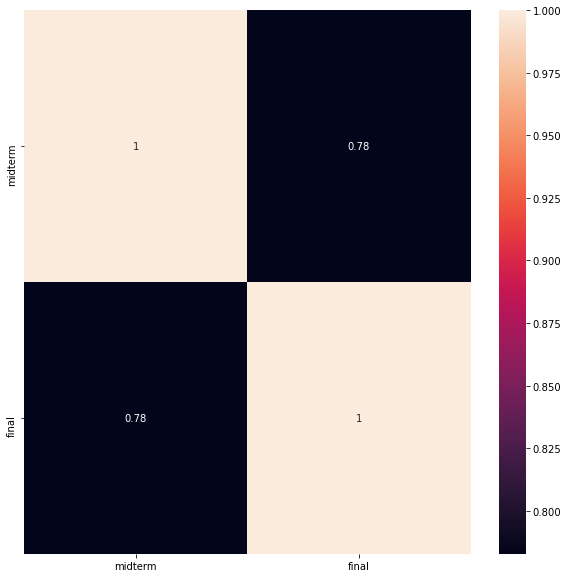

<Figure size 720x720 with 0 Axes>

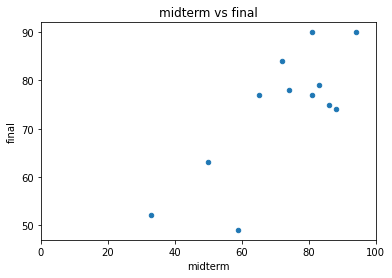

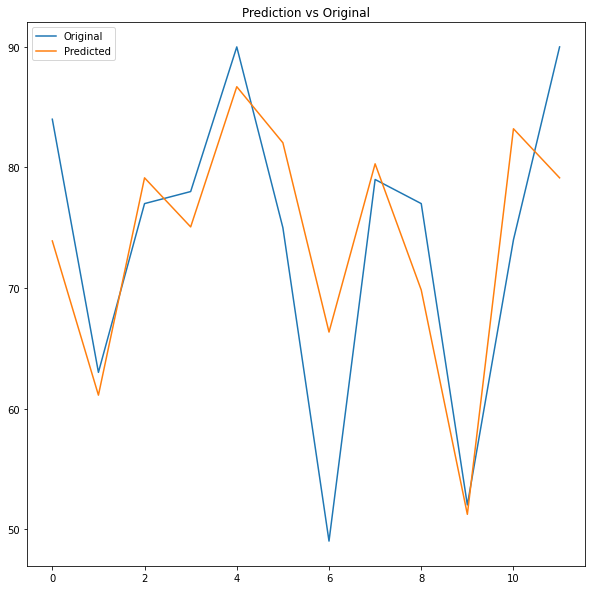


---
The Linear relationship is:




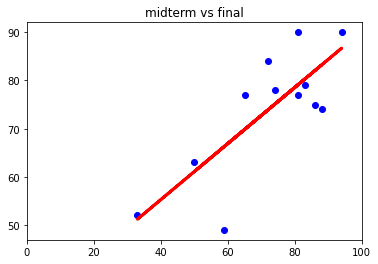

----REPORT----
MAE:  6.1724226887233575
MSE:  61.372787075553845
RMSE:  7.834078572209616
R2:  0.6127899869050231
----DETAIL----


Accuracy: 
 None


Confusion matrix: 
 None


Classification report:
  None
[ 46.98654913  23.2990372  205.6660422   50.04998177 102.362071  ]
Avg RMSE score over 5 folds: 
 8.642931594003262
Stddev RMSE score over 5 folds: 
 3.3124718445381642

---

According to my model, a student who receives 86 on their midterm will get 82 in the final exam.
    



In [12]:
question_one()

In [13]:
def question_two():
    
    #Static
    random_state=14395076
    test_split_size=0.3
    use_full_data=True
    target_column='DefaultedBorrower'
    
    
    
    #Dataframe
    df=read_csv('./specs/borrower_question2.csv',corr_output_filename='./output/borrower_corr.png')
    
    #2a
    df=df.drop('TID',axis=1)
    
    for column in ['HomeOwner', 'MaritalStatus',  'AnnualIncome', 'DefaultedBorrower']:
        df[column]=df[column].astype('category')
    
    one_hot_df=pd.get_dummies(df[['HomeOwner', 'MaritalStatus', 'DefaultedBorrower']],drop_first=True)
    
    #One if Defaulted, 0 if not
    one_hot_df.rename(columns={'DefaultedBorrower_Yes':'DefaultedBorrower'},inplace=True)
    
    df=pd.merge(df[['AnnualIncome']], one_hot_df, left_index=True, right_index=True)
    
    df=df[['HomeOwner_Yes','MaritalStatus_Married','MaritalStatus_Single','DefaultedBorrower','AnnualIncome']]
    
    #split or Not
    if not use_full_data:
        split_dictionary=get_randomised_data(one_hot_df
                                             ,time_column=None
                                             ,test_size=test_split_size
                                             ,random_state=random_state)


        train_df=split_dictionary['Train']
        test_df=split_dictionary['Test']
        
    else:
        train_df=df
        test_df=df
    
    #2b
    tree_high=create_DecisionTree_model(fulldf=df
                                        ,train_df=train_df
                                        ,test_df=test_df
                                        ,target_column=target_column
                                        ,plot_comp=True
                                        ,min_impurity=0.5
                                        ,random_state=14395076
                                        , assess=True
                                        , verbose=True)
    
    #2c
    tree_low=create_DecisionTree_model(fulldf=df
                                        ,train_df=train_df
                                        ,test_df=test_df
                                        ,target_column=target_column
                                        ,plot_comp=True
                                        ,min_impurity=0.1
                                        ,random_state=14395076
                                        , assess=True
                                        , verbose=True)
    
    #Not Required but with NO min impurity
    tree_none=create_DecisionTree_model(fulldf=df
                                        ,train_df=train_df
                                        ,test_df=test_df
                                        ,target_column=target_column
                                        ,plot_comp=True
                                        ,min_impurity=0.0
                                        ,random_state=14395076
                                        , assess=True
                                        , verbose=True)


    
------------------    
Reading Dataframe


   TID HomeOwner MaritalStatus  AnnualIncome DefaultedBorrower
0    1       Yes        Single           125                No
1    2        No       Married           100                No
2    3        No        Single            70                No
3    4       Yes       Married           120                No
4    5        No      Divorced           120               Yes
    
    
------------------ 
The dataframe is described by:    



              count   mean        std   min    25%   50%     75%    max
TID            10.0    5.5   3.027650   1.0   3.25   5.5    7.75   10.0
AnnualIncome   10.0  106.5  45.768135  60.0  77.50  95.0  120.00  220.0


------------------ 
The correlation matrix is:


                   TID  AnnualIncome
TID           1.000000     -0.070161
AnnualIncome -0.070161      1.000000
Decision Tree: The Original Vs Predicted Result Is:


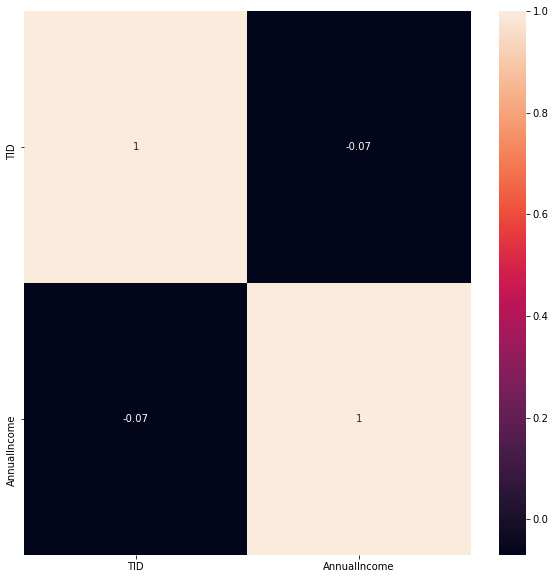

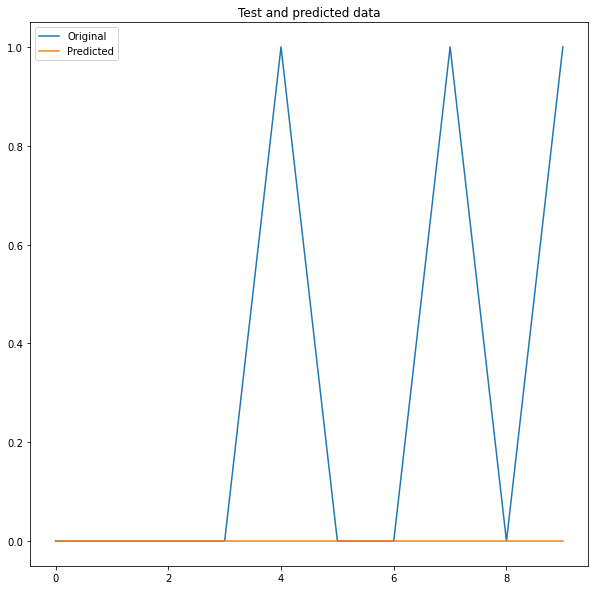

Decision Trree: Tree:


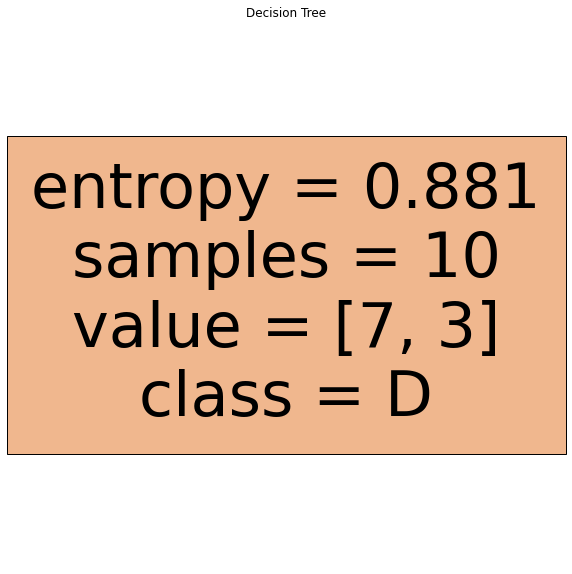

----REPORT----
MAE:  76.5
MSE:  0.3
RMSE:  0.5477225575051661
R2:  -0.4285714285714286
----DETAIL----


Accuracy: 
 0.7


Confusion matrix: 
 [[7 0]
 [3 0]]


Classification report:
  {'0': {'precision': 0.7, 'recall': 1.0, 'f1-score': 0.8235294117647058, 'support': 7}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'accuracy': 0.7, 'macro avg': {'precision': 0.35, 'recall': 0.5, 'f1-score': 0.4117647058823529, 'support': 10}, 'weighted avg': {'precision': 0.48999999999999994, 'recall': 0.7, 'f1-score': 0.5764705882352941, 'support': 10}}
[1.  1.  0.5 0.5 0.5]
Avg Accuracy score over 5 folds: 
 0.8242640687119286
Stddev Accuracy score over 5 folds: 
 0.1434877870428601
Decision Tree: The Original Vs Predicted Result Is:


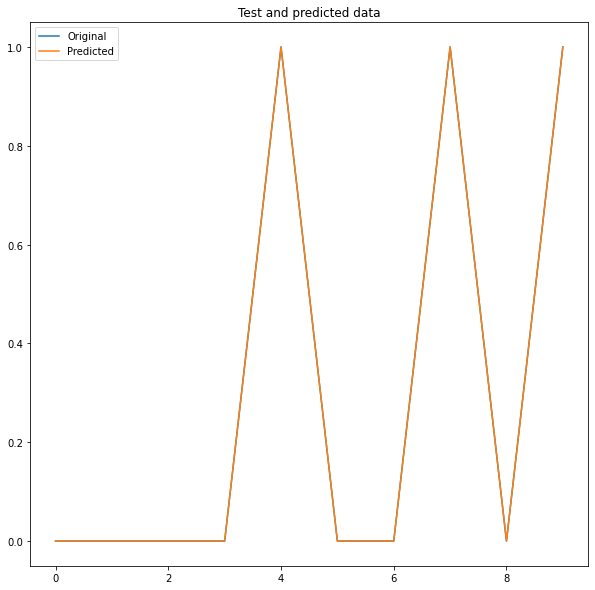

Decision Trree: Tree:


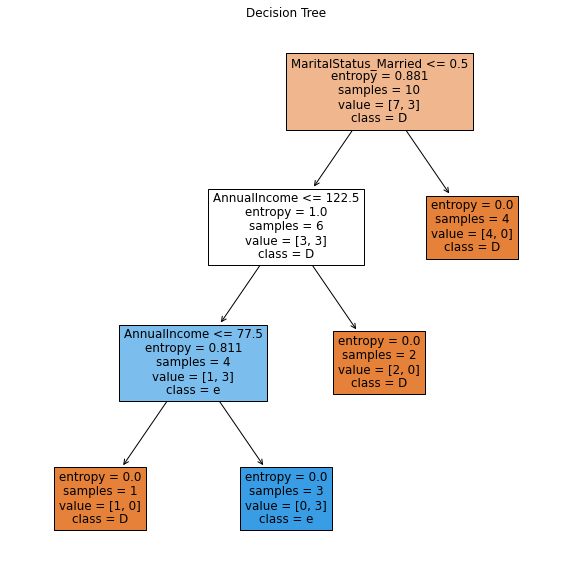

----REPORT----
MAE:  0.0
MSE:  0.0
RMSE:  0.0
R2:  1.0
----DETAIL----


Accuracy: 
 1.0


Confusion matrix: 
 [[7 0]
 [0 3]]


Classification report:
  {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}}
[0.5 0.5 0.5 0.  1. ]
Avg Accuracy score over 5 folds: 
 0.6242640687119285
Stddev Accuracy score over 5 folds: 
 0.3321059657928906
Decision Tree: The Original Vs Predicted Result Is:


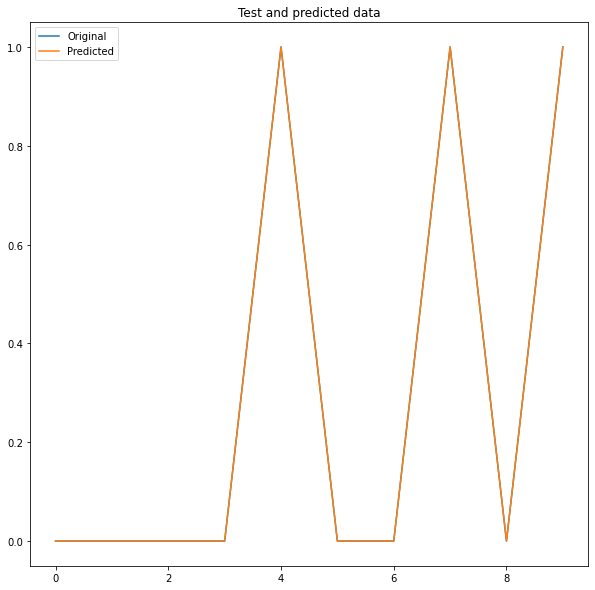

Decision Trree: Tree:


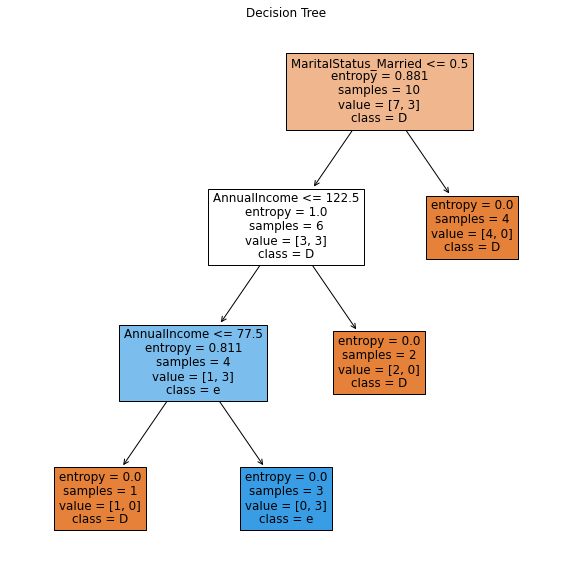

----REPORT----
MAE:  0.0
MSE:  0.0
RMSE:  0.0
R2:  1.0
----DETAIL----


Accuracy: 
 1.0


Confusion matrix: 
 [[7 0]
 [0 3]]


Classification report:
  {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}}
[0.5 0.5 0.5 0.5 1. ]
Avg Accuracy score over 5 folds: 
 0.7656854249492381
Stddev Accuracy score over 5 folds: 
 0.11715728752538097


In [14]:
question_two()

In [15]:
df

NameError: name 'df' is not defined


    
------------------    
Reading Dataframe


   TID HomeOwner MaritalStatus  AnnualIncome DefaultedBorrower
0    1       Yes        Single           125                No
1    2        No       Married           100                No
2    3        No        Single            70                No
3    4       Yes       Married           120                No
4    5        No      Divorced           120               Yes
    
    
------------------ 
The dataframe is described by:    



              count   mean        std   min    25%   50%     75%    max
TID            10.0    5.5   3.027650   1.0   3.25   5.5    7.75   10.0
AnnualIncome   10.0  106.5  45.768135  60.0  77.50  95.0  120.00  220.0


------------------ 
The correlation matrix is:


                   TID  AnnualIncome
TID           1.000000     -0.070161
AnnualIncome -0.070161      1.000000


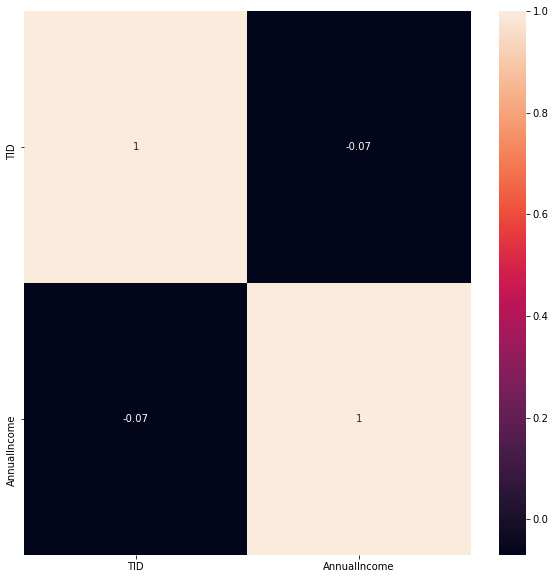

In [16]:
 df=read_csv('./specs/borrower_question2.csv',corr_output_filename='./output/borrower_corr.png')

In [17]:
df

,TID,HomeOwner,MaritalStatus,AnnualIncome,DefaultedBorrower
0,1,Yes,Single,125,No
1,2,No,Married,100,No
2,3,No,Single,70,No
3,4,Yes,Married,120,No
4,5,No,Divorced,120,Yes
5,6,No,Married,60,No
6,7,Yes,Divorced,220,No
7,8,No,Single,85,Yes
8,9,No,Married,75,No
9,10,No,Single,90,Yes
